In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

['sample_submission.csv', 'train.csv', 'test', 'train']


In [2]:
train = pd.read_csv("../input/train.csv")

In [3]:
train.shape

(25361, 2)

In [4]:
train.Id.describe()

count         25361
unique         5005
top       new_whale
freq           9664
Name: Id, dtype: object

In [5]:
train.head(10)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,w_dd88965
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33


In [6]:
y_train = train["Id"]
X_train = train.drop(labels = ["Id"], axis = 1)

In [7]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

def prepareImages(train, shape, path):
    
    x_train = np.zeros((shape, 100, 100, 3))
    count = 0
    
    for fig in train['Image']:
        
        img = image.load_img("../input/"+path+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        x_train[count] = x
        count += 1
    
    return x_train

Using TensorFlow backend.


In [8]:
x_train = prepareImages(train, train.shape[0], "train")

In [9]:
x_train = x_train / 255.0
print("x_train shape: ",x_train.shape)

x_train shape:  (25361, 100, 100, 3)


In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train[0:10]

array([4786, 3808,  662,    0,    0,    0, 4315,    0, 1929, 3237])

In [11]:
y_train.shape

(25361,)

In [12]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 5005)

In [13]:
inverse = label_encoder.inverse_transform([np.argmax(y_train[0,:])])
print(inverse)

['w_f48451c']


In [14]:
print(y_train.shape)
y_train 

(25361, 5005)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu', 
                 input_shape = (100,100,3)))
model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu', 
                 input_shape = (100,100,3)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))

model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation = "softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
__________

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
__________

In [17]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [20]:
history = model.fit(x_train, y_train, epochs = 20, batch_size = 128 , verbose = 2, callbacks=[learning_rate_reduction])

Epoch 1/20
 - 16s - loss: 6.7627 - acc: 0.3136
Epoch 2/20
 - 11s - loss: 5.4398 - acc: 0.3803
Epoch 3/20
 - 11s - loss: 5.1103 - acc: 0.3810
Epoch 4/20
 - 12s - loss: 4.7693 - acc: 0.3818
Epoch 5/20
 - 12s - loss: 4.3860 - acc: 0.3850
Epoch 6/20
 - 12s - loss: 3.9470 - acc: 0.3914
Epoch 7/20
 - 11s - loss: 3.4637 - acc: 0.4057
Epoch 8/20
 - 11s - loss: 2.9408 - acc: 0.4329
Epoch 9/20
 - 11s - loss: 2.3856 - acc: 0.4916
Epoch 10/20
 - 11s - loss: 1.8433 - acc: 0.5781
Epoch 11/20
 - 11s - loss: 1.3807 - acc: 0.6752
Epoch 12/20
 - 11s - loss: 0.9982 - acc: 0.7661
Epoch 13/20
 - 11s - loss: 0.7153 - acc: 0.8359
Epoch 14/20
 - 13s - loss: 0.5345 - acc: 0.8820
Epoch 15/20
 - 11s - loss: 0.3799 - acc: 0.9224
Epoch 16/20
 - 13s - loss: 0.2762 - acc: 0.9487
Epoch 17/20
 - 13s - loss: 0.2160 - acc: 0.9608
Epoch 18/20
 - 11s - loss: 0.1778 - acc: 0.9691
Epoch 19/20
 - 13s - loss: 0.1461 - acc: 0.9748
Epoch 20/20
 - 11s - loss: 0.1112 - acc: 0.9845


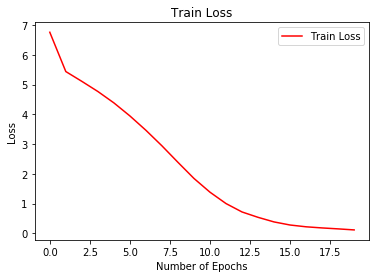

In [21]:
plt.plot(history.history['loss'], color='r', label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

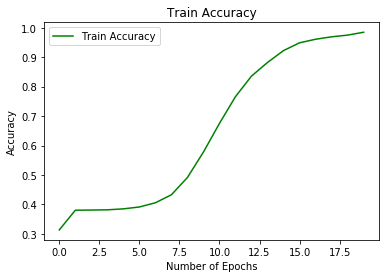

In [22]:
plt.plot(history.history['acc'], color='g', label="Train Accuracy")
plt.title("Train Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
print('Train accuracy of the model: ',history.history['acc'][-1])

Train accuracy of the model:  0.9845431962462048


In [24]:
print('Train loss of the model: ',history.history['loss'][-1])

Train loss of the model:  0.11115858130949322


In [25]:
test = os.listdir("../input/test/")
print(len(test))

7960


In [26]:
col = ['Image']
test_data = pd.DataFrame(test, columns=col)
test_data['Id'] = ''

x_test = prepareImages(test_data, test_data.shape[0], "test")
x_test /= 255

In [27]:
predictions = model.predict(np.array(x_test), verbose=1)

for i, pred in enumerate(predictions):
    test_data.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))

7960/7960 [==============================] - 2s 263us/step


In [28]:
test_data.to_csv('submission.csv', index=False)
test_data.head(10)

,Image,Id
0,fc5634f1c.jpg,new_whale w_9438119 w_df32eec w_5f5f9ae w_53215c6
1,ed344e8e7.jpg,new_whale w_343f088 w_5a8902d w_647da1f w_966b510
2,8cf0fd984.jpg,new_whale w_2d5b0e1 w_c6b4d61 w_a9304b9 w_e54d8f6
3,6513cfc1f.jpg,new_whale w_d6283ba w_7e56d66 w_277d911 w_6bab2bd
4,fd940ccca.jpg,new_whale w_3ebfe7a w_da2d813 w_1b2bf0f w_cf5e3ee
5,9e602e86e.jpg,new_whale w_b9d5945 w_aee9487 w_5b16177 w_a24d7b7
6,7fb06a038.jpg,w_565d73a w_3de579a w_1e85eea w_af493e1 w_ae19ff0
7,10bf25ffb.jpg,new_whale w_6ffc7a1 w_89f521e w_d16eb60 w_9a2b01d
8,6c6c5aec8.jpg,new_whale w_4ea4f59 w_b4e9da5 w_ec1eb03 w_ddb62c2
9,f4bb70495.jpg,new_whale w_aaf3463 w_6a95be3 w_9660cec w_d90a890


In [29]:
model.save('model.hdf5')